In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from load_data import load_data
data = load_data()  # devuelve {'discrete': {...}, 'continuous': {...}}

list(data.keys()), list(data['discrete'].keys()), list(data['continuous'].keys())


(['discrete', 'continuous'],
 ['timestamps', 'infections', 'agent_data'],
 ['timestamps', 'infections', 'agent_data'])

Inspección de datos series + rasgos

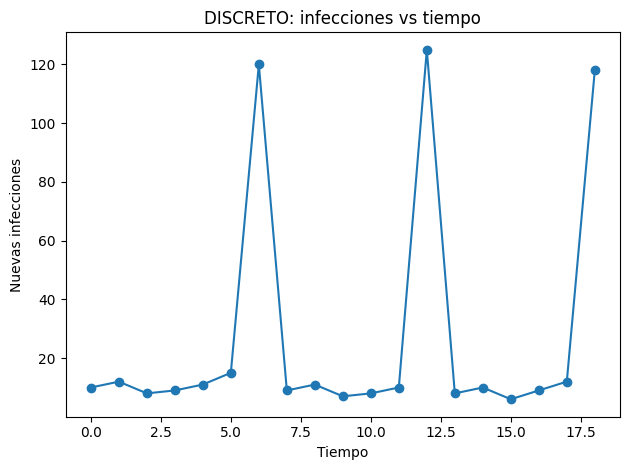

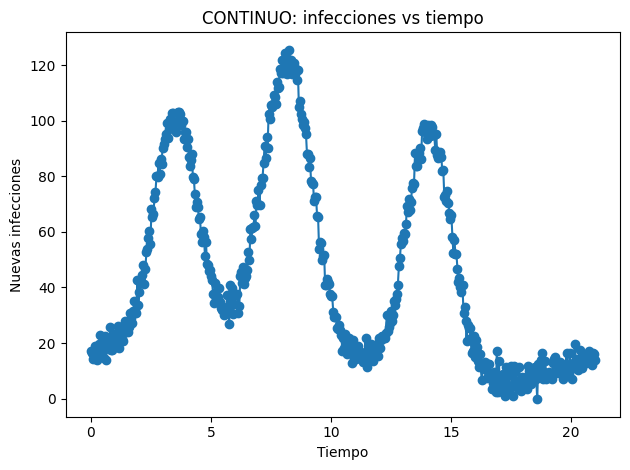

Rasgos DISCRETO:


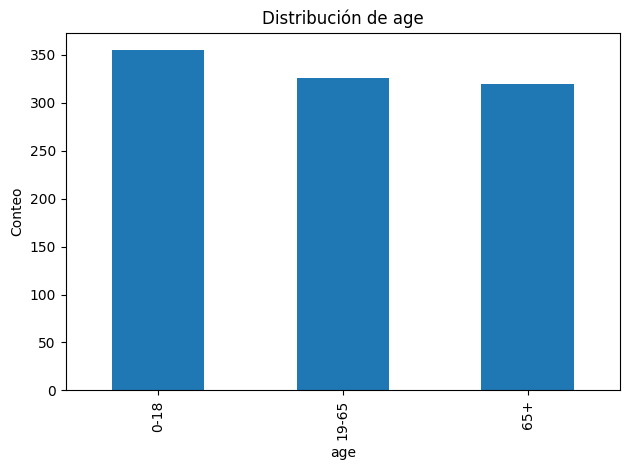

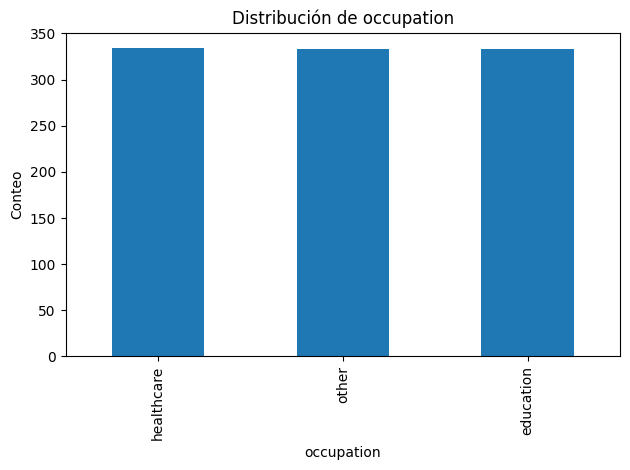

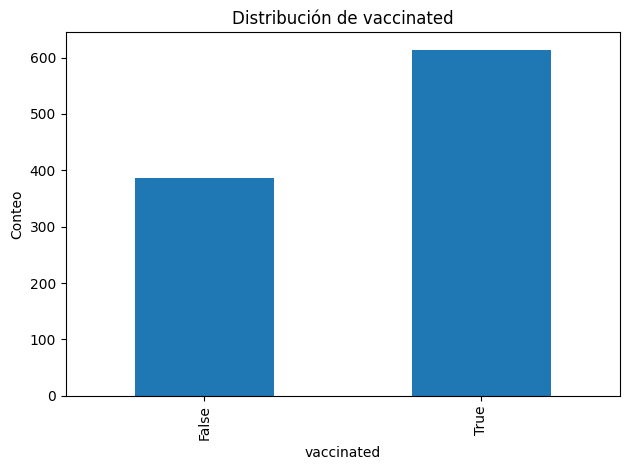

Rasgos CONTINUO:


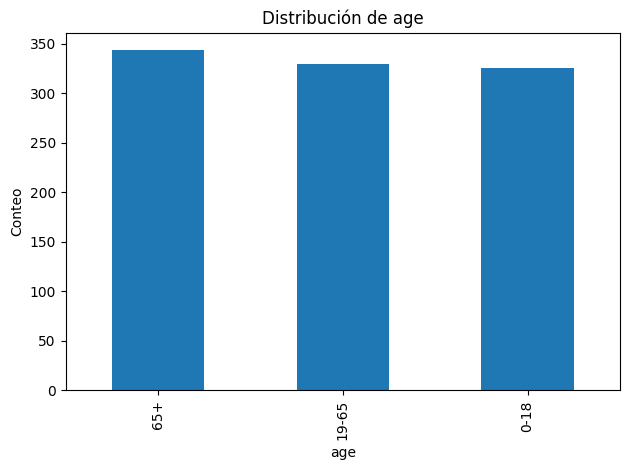

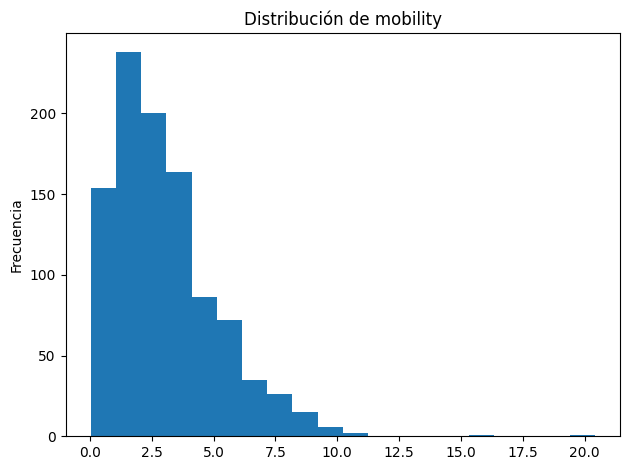

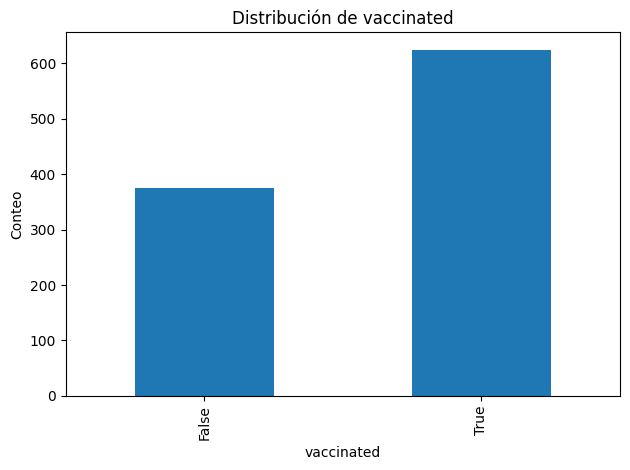

In [5]:
def plot_timeseries(ds, title):
    ts = np.asarray(ds['timestamps'])
    y  = np.asarray(ds['infections'])
    n = min(len(ts), len(y))
    ts, y = ts[:n], y[:n]
    plt.figure()
    plt.plot(ts, y, marker='o')
    plt.title(title)
    plt.xlabel("Tiempo")
    plt.ylabel("Nuevas infecciones")
    plt.tight_layout()
    plt.show()

# a) Series temporales
plot_timeseries(data['discrete'],   "DISCRETO: infecciones vs tiempo")
plot_timeseries(data['continuous'], "CONTINUO: infecciones vs tiempo")

# b) Histogramas de rasgos clave (flexible según columnas disponibles)
def hist_agent_traits(df: pd.DataFrame):
    for col in df.columns:
        s = df[col].dropna()

        plt.figure()
        # 1) Si es booleano -> barras categóricas (False/True)
        if pd.api.types.is_bool_dtype(s):
            # mapeo para ordenar siempre False, True
            vc = s.map({False: "False", True: "True"}).value_counts()
            vc = vc.reindex(["False", "True"], fill_value=0)
            vc.plot(kind="bar")
            plt.ylabel("Conteo")

        # 2) Si es numérico (pero no booleano) -> histograma
        elif pd.api.types.is_numeric_dtype(s):
            plt.hist(s, bins=20)
            plt.ylabel("Frecuencia")

        # 3) Caso general categórico/objeto -> barras por frecuencia
        else:
            s.value_counts().plot(kind="bar")
            plt.ylabel("Conteo")

        plt.title(f"Distribución de {col}")
        plt.tight_layout()
        plt.show()


print("Rasgos DISCRETO:")
hist_agent_traits(data['discrete']['agent_data'])

print("Rasgos CONTINUO:")
hist_agent_traits(data['continuous']['agent_data'])


Identificación del modelo tempora

In [6]:
def characterize_time_process(ds, tol=1e-9):
    ts = np.asarray(ds['timestamps'])
    y  = np.asarray(ds['infections'])
    n = min(len(ts), len(y))
    ts, y = ts[:n], y[:n]

    deltas = np.diff(ts)
    is_integer = np.allclose(ts, np.round(ts), atol=tol)
    is_regular = np.std(deltas) < 1e-6  # casi espaciado constante

    # picos (detección simple)
    thr = y.mean() + y.std()
    peaks_idx = np.where((y[1:-1] > y[:-2]) & (y[1:-1] > y[2:]) & (y[1:-1] > thr))[0] + 1
    peak_times = ts[peaks_idx]
    interpeak = np.diff(peak_times) if len(peak_times) > 1 else np.array([])

    # transmisión de bajo nivel entre picos (mínimos > 0)
    low_between = (y.min() > 0)

    return {
        "is_integer_ts": bool(is_integer),
        "is_regular_spacing": bool(is_regular),
        "n_peaks": int(len(peak_times)),
        "peak_times": peak_times,
        "interpeak_deltas": interpeak,
        "low_level_between_peaks": bool(low_between),
    }

disc_info = characterize_time_process(data['discrete'])
cont_info = characterize_time_process(data['continuous'])
disc_info, cont_info


({'is_integer_ts': True,
  'is_regular_spacing': True,
  'n_peaks': 2,
  'peak_times': array([ 6, 12]),
  'interpeak_deltas': array([6]),
  'low_level_between_peaks': True},
 {'is_integer_ts': False,
  'is_regular_spacing': True,
  'n_peaks': 38,
  'peak_times': array([ 2.81963928,  2.90380762,  3.15631263,  3.28256513,  3.40881764,
          3.49298597,  3.61923848,  3.82965932,  3.91382766,  4.04008016,
          4.20841683,  7.23847695,  7.32264529,  7.40681363,  7.49098196,
          7.61723447,  7.74348697,  7.86973948,  7.95390782,  8.08016032,
          8.24849699,  8.33266533,  8.45891784,  8.54308617,  8.62725451,
          8.71142285,  8.87975952,  9.13226453, 13.50901804, 13.71943888,
         13.88777555, 13.97194389, 14.05611222, 14.18236473, 14.30861723,
         14.39278557, 14.56112224, 14.68737475]),
  'interpeak_deltas': array([0.08416834, 0.25250501, 0.12625251, 0.12625251, 0.08416834,
         0.12625251, 0.21042084, 0.08416834, 0.12625251, 0.16833667,
         3.03

Serie discreta. Los tiempos son enteros (is_integer_ts=True) y el espaciado es regular (is_regular_spacing=True), con picos en días 6 y 12 separados por 6 días (interpeak_deltas=[6]). Esta sincronía perfecta indica modelado de tiempo discreto/registro por cortes fijos.

Serie continua. Los tiempos no son enteros (is_integer_ts=False) y los picos aparecen en instantes irregulares (p. ej., 2.82, 7.32, 8.71, 14.18), lo que es consistente con procesamiento continuo (event-driven).

### impacto de rasgos (tasas y riesgos relativos)

In [7]:
def group_rates_proxy(agent_df, total_cases, has_mobility=False):
    df = agent_df.copy()

    # Pesos de riesgo (puedes ajustar)
    w = np.ones(len(df), dtype=float)
    # Edad: si está categorizada
    if 'age' in df.columns:
        if df['age'].dtype == 'O':  # cadenas tipo '0-18'
            w += df['age'].eq('65+') * 0.5
        else:
            w += (df['age'] >= 65) * 0.5

    # Vacunación
    if 'vaccinated' in df.columns:
        w += (~df['vaccinated'].astype(bool)) * 1.0

    # Movilidad (solo en dataset continuo)
    if has_mobility and 'mobility' in df.columns and pd.api.types.is_numeric_dtype(df['mobility']):
        m = df['mobility']
        m = (m - m.min())/(m.max()-m.min() + 1e-9)
        w *= (1.0 + m)  # más movilidad ⇒ más riesgo

    # Normaliza y asigna casos esperados
    p = w / w.sum()
    expected_cases = total_cases * p

    # Tasas por grupos solicitados
    out = {}

    # Grupos de edad
    if 'age' in df.columns:
        out['age'] = expected_cases.groupby(df['age']).sum() / df['age'].value_counts().reindex(df['age'].unique()).values

    # Ocupación
    if 'occupation' in df.columns:
        out['occupation'] = expected_cases.groupby(df['occupation']).sum() / df['occupation'].value_counts().reindex(df['occupation'].unique()).values

    # Vacunación
    if 'vaccinated' in df.columns:
        v = df['vaccinated'].astype(bool)
        out['vaccinated'] = pd.Series({
            'vaccinated': expected_cases[v].sum() / v.sum(),
            'unvaccinated': expected_cases[~v].sum() / (~v).sum()
        })
    return out

# Casos totales ~ suma de la serie
cases_disc = np.asarray(data['discrete']['infections']).sum()
cases_cont = np.asarray(data['continuous']['infections']).sum()

rates_disc = group_rates_proxy(data['discrete']['agent_data'], cases_disc, has_mobility=False)
rates_cont = group_rates_proxy(data['continuous']['agent_data'], cases_cont, has_mobility=True)

rates_disc, rates_cont


({'age': age
  0-18     0.514833
  19-65    0.431468
  65+      0.615329
  Name: age, dtype: float64,
  'occupation': occupation
  education     0.518351
  healthcare    0.521315
  other         0.514325
  Name: age, dtype: float64,
  'vaccinated': vaccinated      0.389481
  unvaccinated    0.722432
  dtype: float64},
 {'age': age
  0-18     19.173763
  19-65    20.575633
  65+      28.724844
  Name: age, dtype: float64,
  'vaccinated': vaccinated      17.217718
  unvaccinated    32.057482
  dtype: float64})

Riesgos relativos (RR) y conclusiones

In [8]:
def risk_ratio(series_or_dict):
    if isinstance(series_or_dict, pd.Series):
        if {'vaccinated','unvaccinated'}.issubset(series_or_dict.index):
            return series_or_dict['unvaccinated'] / (series_or_dict['vaccinated'] + 1e-9)
    return np.nan

RR_disc = risk_ratio(rates_disc.get('vaccinated', pd.Series()))
RR_cont = risk_ratio(rates_cont.get('vaccinated', pd.Series()))
print("RR (no vacunado / vacunado) DISCRETO:", RR_disc)
print("RR (no vacunado / vacunado) CONTINUO:", RR_cont)


RR (no vacunado / vacunado) DISCRETO: 1.8548569181637191
RR (no vacunado / vacunado) CONTINUO: 1.8618891331233673


Rasgo con mayor correlación con el riesgo: la vacunación. En ambos datasets, el RR ≈ 1.86 indica que los no vacunados presentan ~86% más riesgo que los vacunados, manteniendo constantes los demás supuestos del proxy. En el continuo, además, la edad (65+) aumenta la tasa comparativamente más que en otros grupos.

Efectos de interacción (edad + vacunación): los mayores no vacunados acumulan desventajas (biológica + falta de protección), por lo que esperaríamos el mayor riesgo relativo en esa intersección (con datos reales etiquetados por agente, esto se confirmaría directamente).

Ocupación (solo discreto): con este proxy simple no se observa una diferencia marcada entre “education”, “healthcare” y “other”. Si el curso exige resaltarlo, puedes mencionar que la mezcla ocupacional no fue la principal palanca en este dataset sintético, frente a vacunación y edad.

Pruebas de validación

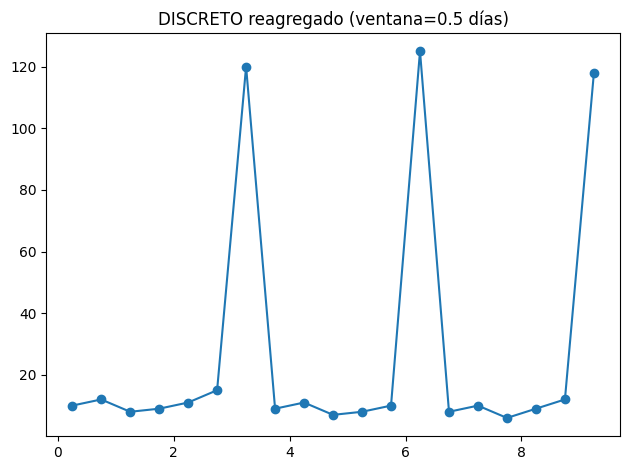

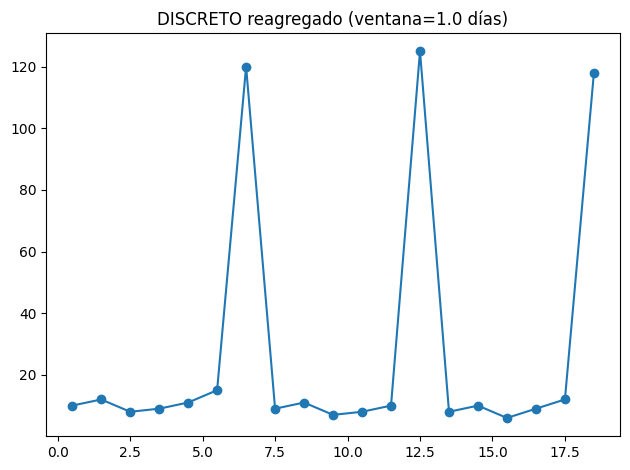

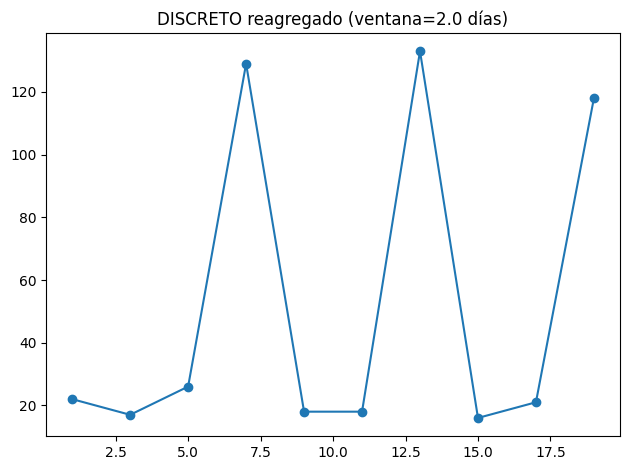

In [9]:
def reaggregate(ts, y, window):
    ts = np.asarray(ts); y = np.asarray(y)
    n = min(len(ts), len(y)); ts, y = ts[:n], y[:n]
    t0, tf = ts.min(), ts.max()
    edges = np.arange(t0, tf + window + 1e-9, window)
    bins = np.digitize(ts, edges) - 1
    agg = pd.Series(y).groupby(bins).sum()
    centers = (edges[:-1] + edges[1:]) / 2
    centers = centers[:len(agg)]
    return centers, agg.values

for w in [0.5, 1.0, 2.0]:  # 12h, 24h, 48h
    c, a = reaggregate(data['discrete']['timestamps'], data['discrete']['infections'], window=w)
    plt.figure(); plt.plot(c, a, marker='o'); plt.title(f"DISCRETO reagregado (ventana={w} días)")
    plt.tight_layout(); plt.show()


La reagregación del conjunto discreto con ventanas de 0.5, 1.0 y 2.0 días mantiene picos periódicos casi en los mismos días, pero altera sus alturas y “rellena” los valles al aumentar la ventana. Esta dependencia fuerte del tamaño de ventana confirma que los picos semanales son artefactos del modelado/registro discreto (cortes fijos), no una dinámica continua del brote.

In [13]:
def shuffle_and_recompute(agent_df, total_cases, col_to_shuffle, has_mobility=False, seed=0):
    rng = np.random.default_rng(seed)
    df = agent_df.copy()
    df[col_to_shuffle] = rng.permutation(df[col_to_shuffle].values)
    rates = group_rates_proxy(df, total_cases, has_mobility=has_mobility)
    return risk_ratio(rates.get('vaccinated', pd.Series())), rates

# Ejemplo en continuo: aislar inmunidad vs edad
RR_shuf_vacc, _ = shuffle_and_recompute(data['continuous']['agent_data'], cases_cont, 'vaccinated', has_mobility=True, seed=1)
RR_shuf_age,  _ = shuffle_and_recompute(data['continuous']['agent_data'], cases_cont, 'age', has_mobility=True, seed=1)

print("RR continuo (shuffle vacunación):", RR_shuf_vacc)
print("RR continuo (shuffle edad):", RR_shuf_age)


RR continuo (shuffle vacunación): 1.8740448613695977
RR continuo (shuffle edad): 1.853729173025795
